In [216]:
import pickle
import random
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import network_rmse, plot_estimates, plot_rmse, plot_traj, rmse
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

sns.set_style("white")

In [217]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
# Simulation parameters
RUNS = 100
FILEPATH_CSV = "./simulations/expf/rmse_rwm.csv"
RANDOM_SEED = None

# Trajectory generator parameters
ndat = 100
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
# q = 10
# r = 1.3
NDIM = 2
TRAJ_MODEL = CAModel(q, r, ndim=NDIM)
INIT_STATE = np.zeros(6)

# Additional filter parameters
c_rwm = 15  # RWM process noise scaling constant
c_cvm = 5
expf = 0.95  # Exponential forgetting param

m = "rwm"

In [219]:
# Generate a trajectory
traj = Trajectory(
    TRAJ_MODEL, n_steps=ndat, init_state=INIT_STATE, R=None, random_seed=RANDOM_SEED
)

# plot_traj(traj)

In [220]:
# No coop nodes
rmse_data = np.zeros((ndat, 5 * NDIM))

# Save state estimates of a random run
random_n = random.randint(0, RUNS - 1)

# Run simulations
for i in range(RUNS):
    ###
    kfs = [
        KalmanFilter(RWModel(c_rwm * q, r, ndim=NDIM), lambda_expf=1.0),
        KalmanFilter(RWModel(c_rwm * q, r, ndim=NDIM), lambda_expf=0.99),
        KalmanFilter(RWModel(c_rwm * q, r, ndim=NDIM), lambda_expf=0.95),
        KalmanFilter(RWModel(c_rwm * q, r, ndim=NDIM), lambda_expf=0.925),
        KalmanFilter(RWModel(c_rwm * q, r, ndim=NDIM), lambda_expf=0.9),
    ]

    # Add observation noise for each node
    traj.simulate(ndat, INIT_STATE)
    traj.add_obs_noise(R=False)

    # Run estimation
    for yt in traj.observations:
        for kf in kfs:
            kf.predict()
            kf.update(yt, log=True)

    # Save results
    rmse_data += network_rmse([], traj, ndat, 2, *kfs)

    if random_n == i:
        # Save state estimates of a random run
        dfs = []
        for kf in kfs:
            dfs.append(kf.to_dataframe(traj))

        fp = "./simulations/expf/"
        for df, kf in zip(dfs, kfs):
            n = m + "_" + str(kf.lambda_expf) + ".csv"
            print(n)
        #     df.to_csv(fp + n, index_label="t")

rwm_1.0.csv
rwm_0.99.csv
rwm_0.95.csv
rwm_0.925.csv
rwm_0.9.csv


In [221]:
# Average the results
rmse_data /= RUNS

In [222]:
# CSV column labels
cols = []
for n in ["100", "990", "950", "925", "900"]:
    for x in ("x1", "x2"):
        cols.append(x + "_" + n)

# Generate CSV files
df = pd.DataFrame(data=rmse_data, columns=cols)
# df.to_csv(FILEPATH_CSV, index_label="t")
df.head()

,x1_100,x2_100,x1_990,x2_990,x1_950,x2_950,x1_925,x2_925,x1_900,x2_900
0,1.161142,0.972167,1.161162,0.972183,1.161240,0.972249,1.161289,0.972290,1.161338,0.972331
1,1.061627,0.907947,1.061924,0.908582,1.063213,0.911265,1.064106,0.913065,1.065071,0.914967
2,0.971722,0.834744,0.971960,0.835571,0.973093,0.839117,0.973957,0.841538,0.974951,0.844127
3,0.902071,0.781397,0.902360,0.782390,0.903828,0.786699,0.905019,0.789681,0.906438,0.792902
4,0.850546,0.738297,0.850862,0.739315,0.852551,0.743788,0.853973,0.746929,0.855697,0.750351


In [223]:
x1_cols = [col for col in df.columns if "x1" in col]
x2_cols = [col for col in df.columns if "x2" in col]

<AxesSubplot:xlabel='t', ylabel='logRMSE'>

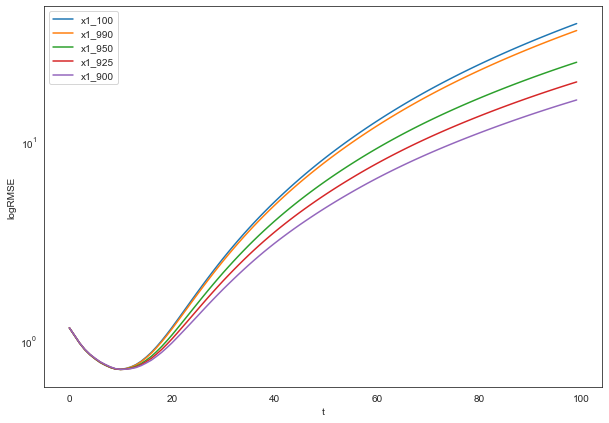

In [224]:
df[x1_cols].plot(figsize=(10, 7), logy=True, ylabel="logRMSE", xlabel="t")

<AxesSubplot:xlabel='t', ylabel='logRMSE'>

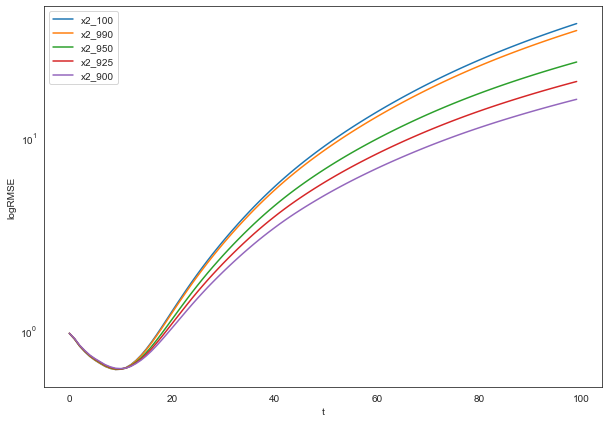

In [225]:
df[x2_cols].plot(figsize=(10, 7), logy=True, ylabel="logRMSE", xlabel="t")

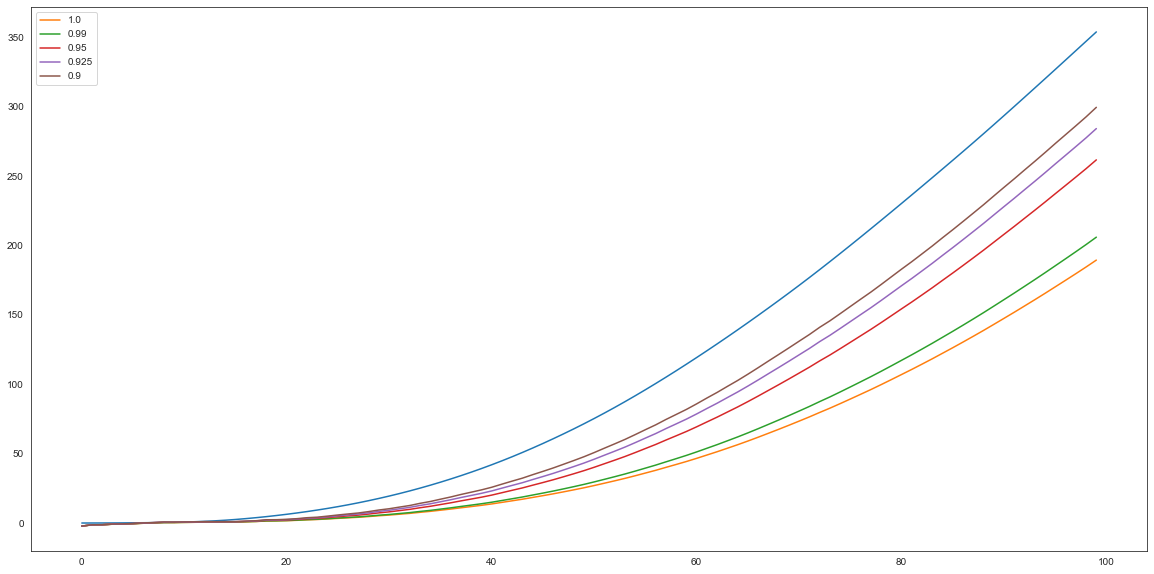

In [226]:
plt.figure(figsize=(20, 10))
plt.plot(traj.states[:, 0])
for kf in kfs:
    plt.plot(kf.history[:, 0], "-", label=str(kf.lambda_expf))

plt.legend()
plt.show()

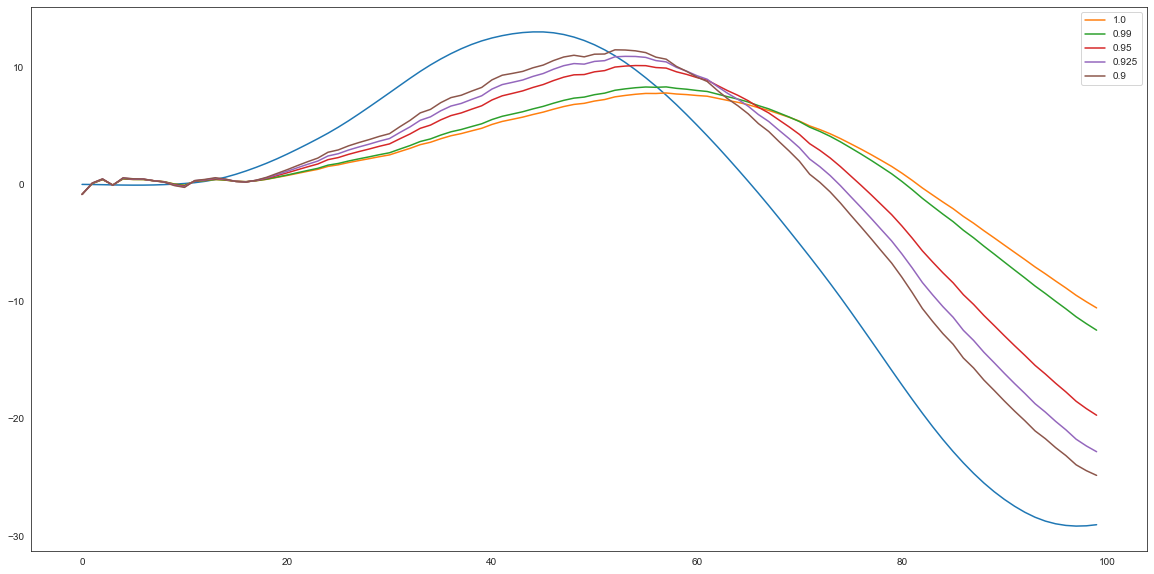

In [227]:
plt.figure(figsize=(20, 10))
plt.plot(traj.states[:, 1])
for kf in kfs:
    plt.plot(kf.history[:, 1], "-", label=str(kf.lambda_expf))

plt.legend()
plt.show()